# Import Libraries

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os,sys
from skimage.feature import greycomatrix, greycoprops
from skimage import color
from skimage import io
from skimage import exposure
import natsort as ns
import multiprocessing
from tqdm import tqdm_notebook
from PIL import Image
from skimage.util import *

# Load Images

In [2]:
path = os.getcwd()

im_dir = r''+ path + '/Zurich_dataset/images_tif/'
gt_dir = r''+ path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

def im_load(path, max_size = 600): # for now, only return highest [max_size] pixels, multiple of patch_size
    """load a TIF image"""
    image = np.asarray(io.imread(path)).astype(float)
    #print(image.shape)
    return np.asarray(image[:max_size,:max_size,:])


def get_im_patches(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

images: 20 
ground truth images: 20 


In [3]:
imgs = np.asarray([im_load(im_dir + im_name, max_size = 512) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name, max_size = 512) for gt_name in gt_names])
print(imgs.shape)

(20, 512, 512, 4)


In [4]:
# Loaded a set of images
def imgs_stretch_eq(imgs):
    imgs_stretch, imgs_eq = [], []
    for im in imgs:
        # Contrast stretching
        p2, p98 = np.percentile(im, (2, 98))
        img_stretch = im.copy()
        img_eq = im.copy()
        for band in range(im.shape[-1]):
            img_stretch[:,:,band] = exposure.rescale_intensity(im[:,:,band], in_range=(p2, p98))
            img_eq[:,:,band] = exposure.equalize_hist(img_stretch[:,:,band])
        
        # append images
        imgs_stretch.append(img_stretch)
        
        imgs_eq.append(img_eq)
        
    # convert to np arrays
    imgs_stretch = np.asarray(imgs_stretch)
    imgs_eq = np.asarray(imgs_eq)
    return imgs_stretch, imgs_eq 

imgs_stretch, imgs_eq = imgs_stretch_eq(imgs)

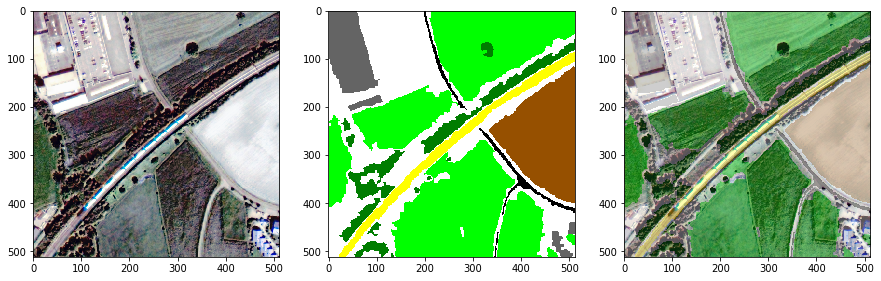

In [5]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 0
overlay = imgs_eq[i][:,:,:3]*.7+gt[i]/255*.3

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs_eq[i][:,:,:3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
plt.show()

In [6]:
imgs = imgs_eq # continue using stretched image

In [7]:
print(np.shape(imgs))
print(np.shape(gt))

(20, 512, 512, 4)
(20, 512, 512, 3)


## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [8]:
# get label corresponding to each color
from collections import OrderedDict

legend = OrderedDict((('Background',[0, 0, 0]),
          ('Roads',[255, 255, 255]),
          ('Buildings',[100, 100, 100]),
          ('Trees',[0, 125, 0]),
          ('Grass',[0, 255, 0]),
          ('Bare Soil',[150, 80, 0]),
          ('Water',[0, 0, 150]),
          ('Railways',[255, 255, 0]),
          ('Swimming Pools',[150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

In [9]:
def gt_color_to_label(gt, maj = False):
    """
    Transform a set of GT image in value range [0, 255] of shape (n_images, width, height, 3) 
    to a set of GT labels of shape (n_images, width, height)
    """
    
    # sum of distinct color values
    gt_new = np.sum(gt,axis=3).astype(int) 

    # replace colors by new values
    for i in range(len(colors)):
        gt_new[gt_new == np.sum(colors[i])] = i #np.argsort(colors)[i]
    
    if maj:
        # return only majority label for each patch
        gt_maj_label = []
        for i in range(len(gt)):
            counts = np.bincount(gt_new[i].flatten())
            gt_maj_label.append(np.argmax(counts))

        gt_new = np.asarray([gt_maj_label]).T
        
    return gt_new

def gt_label_to_color(gt):
    """
    Transform a set of GT labels of shape (n_images, width, height)
    to a set of GT images in value range [0,1] of shape (n_images, width, height, 3) """
    gt_new = np.zeros(gt.shape+(3,))
    for i in range(len(colors)): # loop colors
        gt_new[gt == i,:] = np.divide(colors[i],255)
    return gt_new

In [10]:
gt_maj_label = gt_color_to_label(gt)
print("Unique Labels in GT: ", np.unique(gt_maj_label))
print(np.shape(gt_maj_label))
gt = gt_maj_label

Unique Labels in GT:  [0 1 2 3 4 5 6 7 8]
(20, 512, 512)


In [11]:
gt_colors = gt_label_to_color(gt_maj_label)

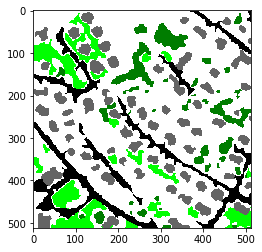

In [12]:
plt.imshow(gt_colors[3])

## Get patches

In [13]:
def get_padded_patches(images, patch_size = 16, window_size = 64):
    """
    get padded (mirror) patches for all images
    """
    patches = []
    for im in tqdm_notebook(images):
        patches_im = np.zeros([int(im.shape[0]/patch_size),int(im.shape[0]/patch_size), window_size, window_size, im.shape[2]])    
        for i in range(np.shape(im)[2]):
            padded = np.lib.pad(im[:,:,i], int(np.floor((window_size-patch_size)/2)), 'reflect')    
            patches_im[:,:,:,:,i] = view_as_windows(padded, window_size, step=patch_size)
            
        n_patches = int((im.shape[0]/patch_size)**2) # 25*25 = 625 per image
        patches_im = np.reshape(patches_im, (n_patches, window_size, window_size, im.shape[2]))

        # TODO reshape patches (first dim)
        patches.append(patches_im)
    patches = np.array(patches)
    patches =  np.asarray([patches[i][j] for i in range(len(patches)) for j in range(len(patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return patches

def get_gt_patches(images_gt, patch_size = 16):
    """
    get ground truth patches for all images
    """
    gt_patches = []
    for im in tqdm_notebook(images_gt):
        patches_im_gt = view_as_blocks(im, block_shape=(patch_size, patch_size))         
        n_patches = int((im.shape[0]/patch_size)**2) # 25*25 = 625 per image
        patches_im_gt = np.reshape(patches_im_gt, (n_patches, patch_size, patch_size))

        gt_patches.append(patches_im_gt)
    gt_patches = np.array(gt_patches)
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return np.asarray(gt_patches)

In [14]:
print(imgs.shape)
print(gt.shape)

(20, 512, 512, 4)
(20, 512, 512)


In [15]:
im_patches = get_padded_patches(imgs, patch_size = 128, window_size = 128)
gt_patches = get_gt_patches(gt, patch_size = 128)
print(im_patches.shape)
print(gt_patches.shape)



(320, 128, 128, 4)
(320, 128, 128)


In [16]:
gt_patches_color=gt_label_to_color(gt_patches)

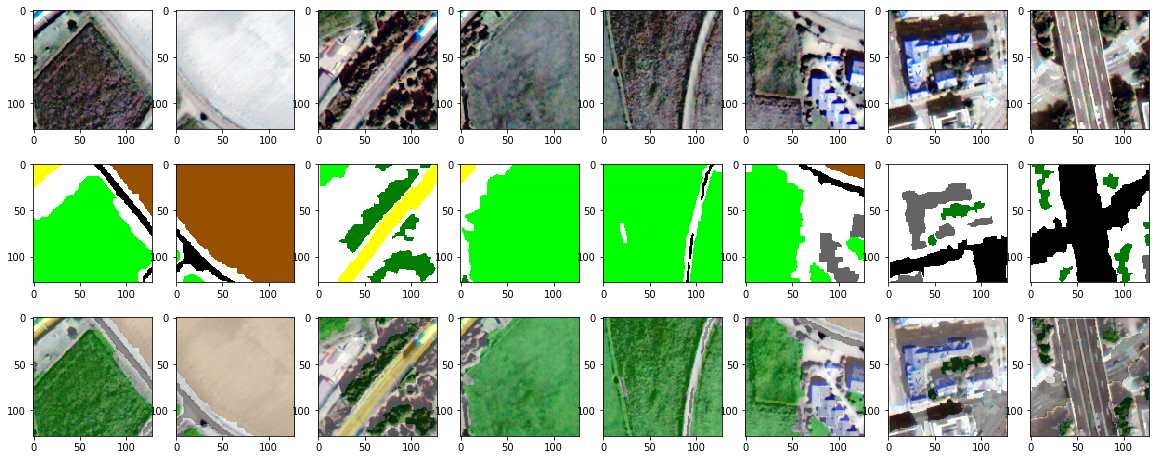

In [17]:
imgs_row = 8
fig, axes = plt.subplots(3,imgs_row)
fig.set_size_inches(20,8)
offset = 10
alpha=.3
for i in range(offset, offset + imgs_row):
    axes[0][i-offset].imshow(im_patches[i][:,:,:3])
    axes[1][i-offset].imshow(gt_label_to_color(gt_patches[i]))
    axes[2][i-offset].imshow(gt_label_to_color(gt_patches[i])*alpha+im_patches[i][:,:,:3]*(1-alpha))

[0 1 2 3 4 5 6 7 8] [ 765495 2098531 1191470  460171  390497   45045  183389  103897    4385]


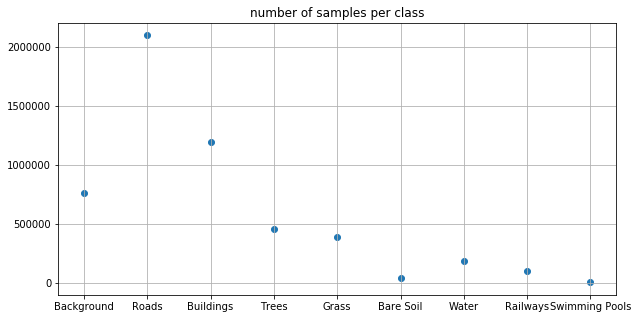

In [18]:
# print some statistics for the new labels
unique, counts = np.unique(gt,return_counts=True)
print(unique, counts)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)
ax.scatter(unique,counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

# Keras test

In [19]:
np.random.seed(42)

from __future__ import print_function

import h5py
import sklearn # accuracy metrics
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import tensorflow as tf
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers 

import keras
import keras.backend as K
from keras import metrics
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.utils import to_categorical
import keras.losses
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import *

/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(gt.flatten()), gt.flatten())
class_weights[0] = 1 # give less weight to background label class
class_weights[8] = 10 # give less weight to swimming pool class
print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f"%(names[i],w))

x_train, x_val, y_train, y_val  = train_test_split(imgs, gt, test_size=.2, random_state = 42)

Class weights:
     Background: 1.000
          Roads: 0.278
      Buildings: 0.489
          Trees: 1.266
          Grass: 1.492
      Bare Soil: 12.932
          Water: 3.177
       Railways: 5.607
 Swimming Pools: 10.000


In [21]:
n_classes = 9

# if we want to use all data for training 
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)

# make y data categorical
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)

In [22]:
# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

(16, 512, 512, 4)
(16, 512, 512, 9)
(4, 512, 512, 4)
(4, 512, 512, 9)


## UNET

In [23]:
def get_unet():
    
    # model parameters
    n_classes = 9
    input_shape=x_train.shape[1:]
    reg = 1e-6
    inputs = Input(input_shape)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['categorical_accuracy'])

    return model

In [24]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

# callbacks (evaluated every epoch)
# keep track of the accuracy over epochs
callback_history = AccuracyHistory()

# stop early if after several epochs the accuracy doesn't improive
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto', 
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
filepath="weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')

In [79]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

batch_size = 2000
epochs = 2000

def model_train(model, data_augmentation = True):
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              class_weight = class_weights,
              validation_data = (x_val, y_val),
              callbacks=[callback_history, 
                         callback_earlystop, 
                         callback_lr, 
                         callback_checkpoint])
    else:
        print('Using real-time data augmentation.')

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                            epochs=epochs,
                            verbose=1,
                            class_weight = class_weights,
                            validation_data=(x_val, y_val),
                            callbacks=[callback_history, 
                                       callback_earlystop,
                                       callback_lr,
                                       callback_checkpoint],
                            workers=multiprocessing.cpu_count()-1,
                            use_multiprocessing=True)
        

# train the model
model = get_unet()
#model.load_weights('weights-improvement.hdf5')
model_train(model, data_augmentation = True)

# Prediction

In [80]:
# save the model
model.save('model_unet_64_aug.h5')  # save model, weights
#del model  # deletes the existing modelon set

In [81]:
score = model.evaluate(x_val, y_val, batch_size = 1, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0948327537626028
Test accuracy: 0.5019779205322266


In [82]:
y_pred = model.predict(x_val, batch_size = 3, verbose = 1)
y_pred = np.argmax(y_pred,axis=-1)
y_val_fig = np.argmax(y_val,axis=-1) # test gt, converting back to labels for figure

64/64 [==============================] - 1s 9ms/step


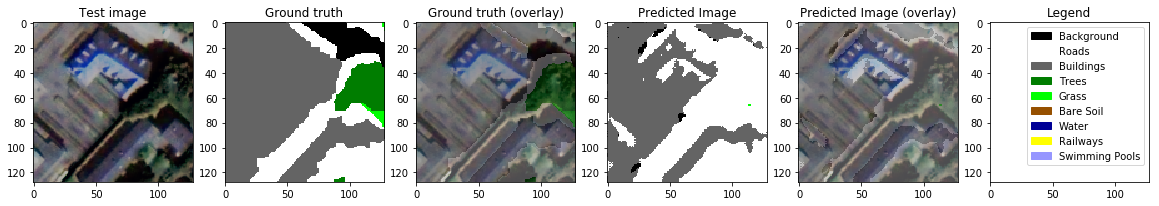

In [83]:
# plot prediction results

im_idx = 5
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_val[im_idx][:,:,:3]*(1-alpha)
fig_val = gt_label_to_color(y_val_fig[im_idx])
fig_pred = gt_label_to_color(y_pred[im_idx])

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_val)
axes[2].imshow(fig_val*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = (v/255 for v in c)) for n,c in legend_data]
labels = [n for n,c in legend_data]
axes[5].legend(handles,labels)

In [92]:
# Validation accuracy
y_pred_val = model.predict(x_val)
# convert 2 classes to one
y_pred_val = np.argmax(y_pred_val, axis = -1)
y_val_labels = np.argmax(y_val, axis = -1)
print("Validation accuracy: ")
print(sklearn.metrics.accuracy_score(y_pred_val.flatten(),y_val_labels.flatten()))
print(sklearn.metrics.classification_report(y_pred_val.flatten(),y_val_labels.flatten(),target_names=labels))

Validation accuracy: 
0.5019779205322266
                precision    recall  f1-score   support

    Background       0.05      0.51      0.08     14404
         Roads       0.78      0.56      0.65    583839
     Buildings       0.72      0.38      0.50    392242
         Trees       0.00      0.00      0.00         0
         Grass       0.34      0.91      0.50     28468
     Bare Soil       0.00      0.00      0.00         0
         Water       0.53      0.69      0.60     29623
      Railways       0.00      0.00      0.00         0

   avg / total       0.73      0.50      0.58   1048576



/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 8, does not match size of target_names, 9
  .format(len(labels), len(target_names))
/home/cyrilwendl/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
